In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import glob, re, sys
sys.path.append('/t3home/gcelotto/ggHbb/NN')
from functions import loadMultiParquet, cut, getXSectionBR
from helpersForNN import preprocessMultiClass, scale, unscale
from applyMultiClass_Hpeak import getPredictions, splitPtFunc

In [34]:
# Load data in df and dfData
pTClass, nReal, nMC = 0, 100, -1
paths = [
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/Data1A/",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/GluGluHToBB/",
            ]
isMCList = [0, 1]

# load the files where the prediction is available

# get predictions
pathToPredictions = "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/NNpredictions"
fileNumberList = []
for isMC in isMCList:
    fileNumberProcess = []
    fileNamesProcess = glob.glob(pathToPredictions+"/yMC%d_fn*pt%d*.parquet"%(isMC, pTClass))
    for fileName in fileNamesProcess:
        match = re.search(r'_fn(\d+)_pt', fileName)
        if match:
            fn = match.group(1)
            fileNumberProcess.append(int(fn))
            
        else:
            pass
            #print("Number not found")
    fileNumberList.append(fileNumberProcess)
    print(len(fileNumberProcess), " predictions files for process MC : ", isMC)


columns= ['sf',         'dijet_mass',   'jet1_pt',      'jet2_pt',
          'jet1_mass',  'jet2_mass',    'jet1_eta',     'jet2_eta',
          'jet1_qgl',   'jet2_qgl',     'jet3_mass',    'jet3_qgl',
          'muon_sIP3d', 'jet2_btagDeepFlavB',
          'muon_charge', 'muon2_charge', 'jet2_leptonicCharge', 'dijet_pt']
dfs, numEventsList, fileNumberList = loadMultiParquet(paths=paths, nReal=nReal, nMC=nMC, columns=columns, returnNumEventsTotal=True, selectFileNumberList=fileNumberList, returnFileNumberList=True)
pTmin, pTmax, suffix = [[0,-1,'inclusive'], [0, 30, 'lowPt'], [30, 100, 'mediumPt'], [100, -1, 'highPt']][pTClass]    


dfs = preprocessMultiClass(dfs, pTmin, pTmax, suffix)   # get the dfs with the cut in the pt class
dfData, df = dfs


1017  predictions files for process MC :  0
154  predictions files for process MC :  1
Looking for a specific list of  1017  files expected
Found 1004 files for process 0
100 files for process 0


Looking for a specific list of  154  files expected
Found 154 files for process 1
154 files for process 1


lenght of elements returned in fileNumberList
[100, 154]
Preprocessing...
Performing the cut in pt and eta
New function
Initial len df 0 : 14453719
Eff. cut mass  83.78516863514508
Pt cut class applied 0--1
Filling jet1 qgl with 0. 0
Filling jet2 qgl with 0. 0 

Initial len df 1 : 777400
Eff. cut mass  94.59111778769862
Pt cut class applied 0--1
Filling jet1 qgl with 0. 0
Filling jet2 qgl with 0. 0 



In [35]:

YPred_data, YPred_H = getPredictions(fileNumberList, pathToPredictions, splitPt=False, masks=None, isMC=isMCList, pTClass=pTClass)


In [36]:
# save the weights for luminosity normalization
W_H = df.sf*getXSectionBR()/numEventsList[1]*nReal*0.774/1017*1000
print(len(df)/numEventsList[1])
df['weights']=W_H
df['NN_0']=YPred_H[:,0]
dfData['NN_0']=YPred_data[:,0]
df['NN_1']=YPred_H[:,1]
dfData['NN_1']=YPred_data[:,1]
df['NN_2']=YPred_H[:,2]
dfData['NN_2']=YPred_data[:,2]
maskNN_S = (df.NN_1>0.34) & (df.NN_0<0.22)
maskNN_B = (dfData.NN_1>0.34) & (dfData.NN_0<0.22)

0.0603045266231483


In [37]:
# two functions for s/sqrt(b) and s/b
def sig(df, dfData):
    s = df.weights[(df.dijet_mass > 100) & (df.dijet_mass<150)].sum()
    b = len(dfData[(dfData.dijet_mass > 100) & (dfData.dijet_mass<150)])

    return s/np.sqrt(b)

def sb_ratio(df, dfData):
    s = df.weights[(df.dijet_mass > 100) & (df.dijet_mass<150)].sum()
    b = len(dfData[(dfData.dijet_mass > 100) & (dfData.dijet_mass<150)])

    return s/b


In [38]:
# check s/sqrt(b) improvement using R1, R2, R3
base_sig = sig(df, dfData)
base_sb = sb_ratio(df, dfData)
currentLumi = nReal*0.774/1017
print("Luminosity used : ", currentLumi)
print("Baseline")
print("SIG:", base_sig)
print("S/B:", base_sb)

m1S = df.muon2_charge!=999
m1B = dfData.muon2_charge!=999
m1Sig = sig(df[m1S], dfData[m1B])
print("\nR1 ")
print("SIG:", m1Sig)
print("S/B:", sb_ratio(df[m1S], dfData[m1B]))

out1S = df.muon2_charge==999
out1B = dfData.muon2_charge==999
out1Sig = sig(df[out1S], dfData[out1B])
print("Outside R1")
print("SIG:", out1Sig)
print("S/B:", sb_ratio(df[out1S], dfData[out1B]))
print("Final Signifiance (R1+not R1)", np.sqrt(m1Sig**2 + out1Sig**2))


m2S = (df.muon2_charge==999) & (abs(df.jet2_leptonicCharge)==1)
m2B = (dfData.muon2_charge==999) & (abs(dfData.jet2_leptonicCharge)==1)
m2Sig = sig(df[m2S], dfData[m2B])
print("\nR2 ")
print("SIG:", m2Sig)
print("S/B:", sb_ratio(df[m2S], dfData[m2B]))

m3S = (df.muon2_charge==999) & (abs(df.jet2_leptonicCharge)==0)
m3B = (dfData.muon2_charge==999) & (abs(dfData.jet2_leptonicCharge)==0)
m3Sig = sig(df[m3S], dfData[m3B])
print("\nR3")
print("SIG:", m3Sig)
print("S/B:", sb_ratio(df[m3S], dfData[m3B]))

print("Final Signifiance (R1+R2+R3) ", np.sqrt(m1Sig**2 + m2Sig**2 + m3Sig**2))
print("Improved Significance", np.sqrt(m1Sig**2 + m2Sig**2 + m3Sig**2)/base_sig)

print("Three regions orthogonal : ",len(df)==(np.sum(m1S) + np.sum(m2S) + np.sum(m3S)))
print("Three regions orthogonal : ",len(dfData)==(np.sum(m1B) + np.sum(m2B) + np.sum(m3B)))


Luminosity used :  0.07610619469026549
Baseline
SIG: 0.05042976554854775
S/B: 3.9288913574734235e-05

R1 
SIG: 0.026227870941299514
S/B: 0.00037114085933463844
Outside R1
SIG: 0.049060166996752246
S/B: 3.8279945369965196e-05
Final Signifiance (R1+not R1) 0.05563093743469259

R2 
SIG: 0.024144627993649227
S/B: 6.688006009638952e-05

R3
SIG: 0.04404238071357713
S/B: 3.5815017253371625e-05
Final Signifiance (R1+R2+R3)  0.056662117627078186
Improved Significance 1.1235847918533484
Three regions orthogonal :  True
Three regions orthogonal :  True


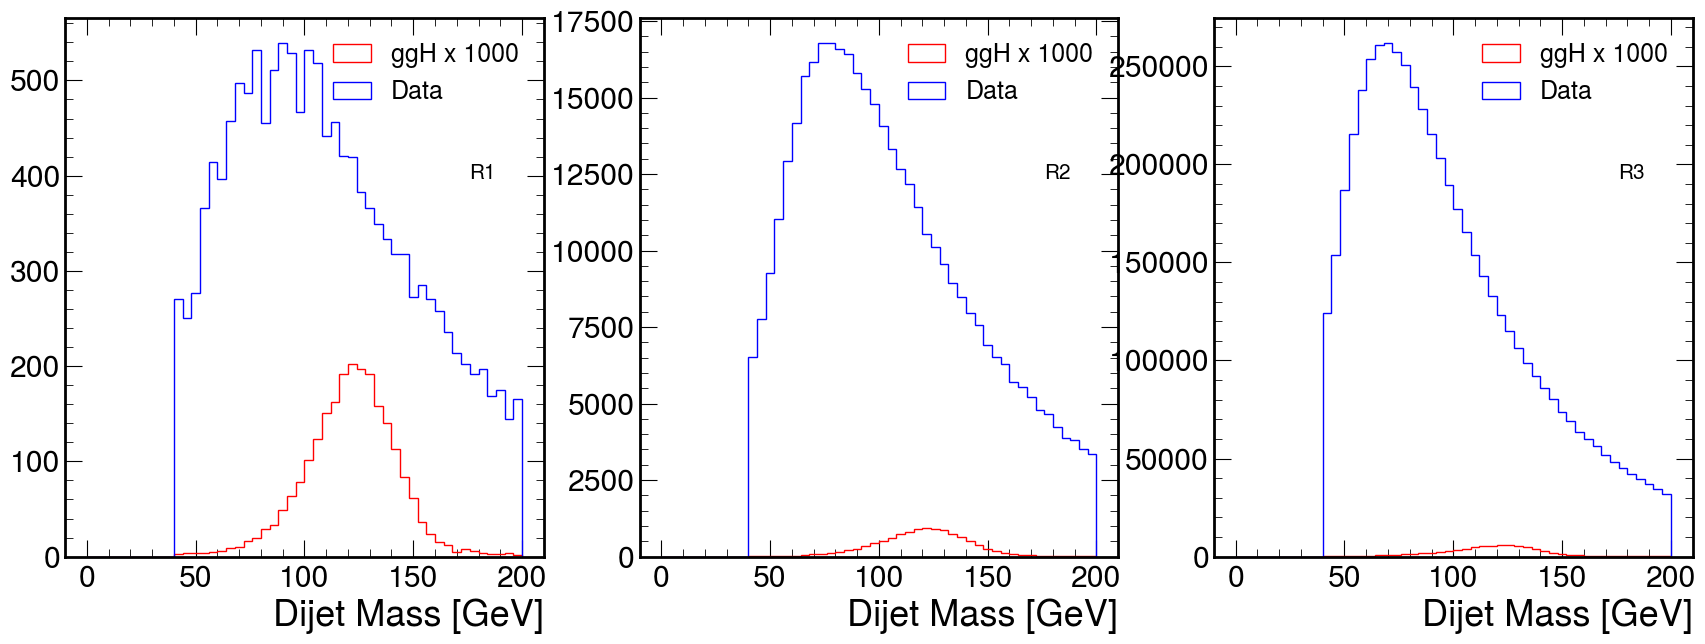

In [39]:
# spectrum in the 3 regions
fig, ax = plt.subplots(1, 3, figsize=(21,7))
bins = np.linspace(0, 200, 51)
ax[0].hist(df.dijet_mass[m1S],       bins=bins, weights=df.weights[m1S]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[0].hist(dfData.dijet_mass[m1B],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[1].hist(df.dijet_mass[m2S],       bins=bins, weights=df.weights[m2S]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[1].hist(dfData.dijet_mass[m2B],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[2].hist(df.dijet_mass[m3S],       bins=bins, weights=df.weights[m3S]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[2].hist(dfData.dijet_mass[m3B],   bins=bins, histtype=u'step', color='blue', label='Data')
for id,ax_ in enumerate(ax):
    ax_.set_xlabel("Dijet Mass [GeV]")
    ax_.legend(fontsize=18)
    ax_.text(x=0.9,y=0.7,s=["R1","R2","R3"][id], transform = ax_.transAxes, ha='right', fontsize=15)


## AFter NN

In [40]:
# after NN
# check s/sqrt(b) improvement using R1, R2, R3
base_sig_NN = sig(df[maskNN_S], dfData[maskNN_B])
currentLumi = nReal*0.774/1017
print("Luminosity used : ", currentLumi)
print("Baseline")
print("SIG:", base_sig)

m1S = df.muon2_charge!=999
m1B = dfData.muon2_charge!=999
m1Sig_NN = sig(df[(m1S) & (maskNN_S)], dfData[(m1B) & (maskNN_B)])
print("\nR1 ")
print("SIG:", m1Sig)


print("Final Signifiance (R1+not R1)", np.sqrt(m1Sig**2 + out1Sig**2))


m2S = (df.muon2_charge==999) & (abs(df.jet2_leptonicCharge)==1)
m2B = (dfData.muon2_charge==999) & (abs(dfData.jet2_leptonicCharge)==1)
m2Sig_NN = sig(df[(m2S) & (maskNN_S)], dfData[(m2B) & (maskNN_B)])
print("\nR2 ")
print("SIG:", m2Sig)


m3S = (df.muon2_charge==999) & (abs(df.jet2_leptonicCharge)==0)
m3B = (dfData.muon2_charge==999) & (abs(dfData.jet2_leptonicCharge)==0)
m3Sig_NN = sig(df[(m3S) & (maskNN_S)], dfData[(m3B) & (maskNN_B)])
print("\nR3")
print("SIG:", m3Sig)

print("Final Signifiance (R1+R2+R3) ", np.sqrt(m1Sig_NN**2 + m2Sig_NN**2 + m3Sig_NN**2))
print("Improved Significance", np.sqrt(m1Sig_NN**2 + m2Sig_NN**2 + m3Sig_NN**2)/base_sig_NN)

Luminosity used :  0.07610619469026549
Baseline
SIG: 0.05042976554854775

R1 
SIG: 0.026227870941299514
Final Signifiance (R1+not R1) 0.05563093743469259

R2 
SIG: 0.024144627993649227

R3
SIG: 0.04404238071357713
Final Signifiance (R1+R2+R3)  0.09059741474419034
Improved Significance 1.0205745786792007


## Dijet pT

In [17]:
# compute s/sqrt(b) in 3 regions of dijet_pt
base_sig = sig(df, dfData)
base_sb = sb_ratio(df, dfData)
currentLumi = nReal*0.774/1017
print("Luminosity used : ", currentLumi)
print("Baseline")
print("SIG:", base_sig)
print("S/B:", base_sb)

mLowS = df.dijet_pt<30
mLowB = dfData.dijet_pt<30
mLowSig = sig(df[mLowS], dfData[mLowB])
print("\nR Low ")
print("SIG:", mLowSig)
print("S/B:", sb_ratio(df[mLowS], dfData[mLowB]))


mMediumS = (df.dijet_pt>30) & (df.dijet_pt<100)
mMediumB = (dfData.dijet_pt>30) & (dfData.dijet_pt<100)
mMediumSig = sig(df[mMediumS], dfData[mMediumB])
print("\nR Medium ")
print("SIG:", mMediumSig)
print("S/B:", sb_ratio(df[mMediumS], dfData[mMediumB]))

mHighS = df.dijet_pt>100
mHighB = dfData.dijet_pt>100
mHighSig = sig(df[mHighS], dfData[mHighB])
print("\nR High")
print("SIG:", mHighSig)
print("S/B:", sb_ratio(df[mHighS], dfData[mHighB]))

print("Final Signifiance (R1+R2+R3) ", np.sqrt(mLowSig**2 + mMediumSig**2 + mHighSig**2))
print("Improved Significance", np.sqrt(mLowSig**2 + mMediumSig**2 + mHighSig**2)/base_sig)

print("Three regions orthogonal : ",len(df)==(np.sum(mLowS) + np.sum(mMediumS) + np.sum(mHighS)))
print("Three regions orthogonal : ",len(dfData)==(np.sum(mLowB) + np.sum(mMediumB) + np.sum(mHighB)))


Luminosity used :  0.07610619469026549
Baseline
SIG: 0.05042976554854775
S/B: 3.9288913574734235e-05

R Low 
SIG: 0.0312131778132854
S/B: 3.458740962798825e-05

R Medium 
SIG: 0.03271493249200772
S/B: 3.7486300459142605e-05

R High
SIG: 0.029959932462836722
S/B: 0.00011204927977197559
Final Signifiance (R1+R2+R3)  0.05424137563095291
Improved Significance 1.0755825461598825
Three regions orthogonal :  True
Three regions orthogonal :  True


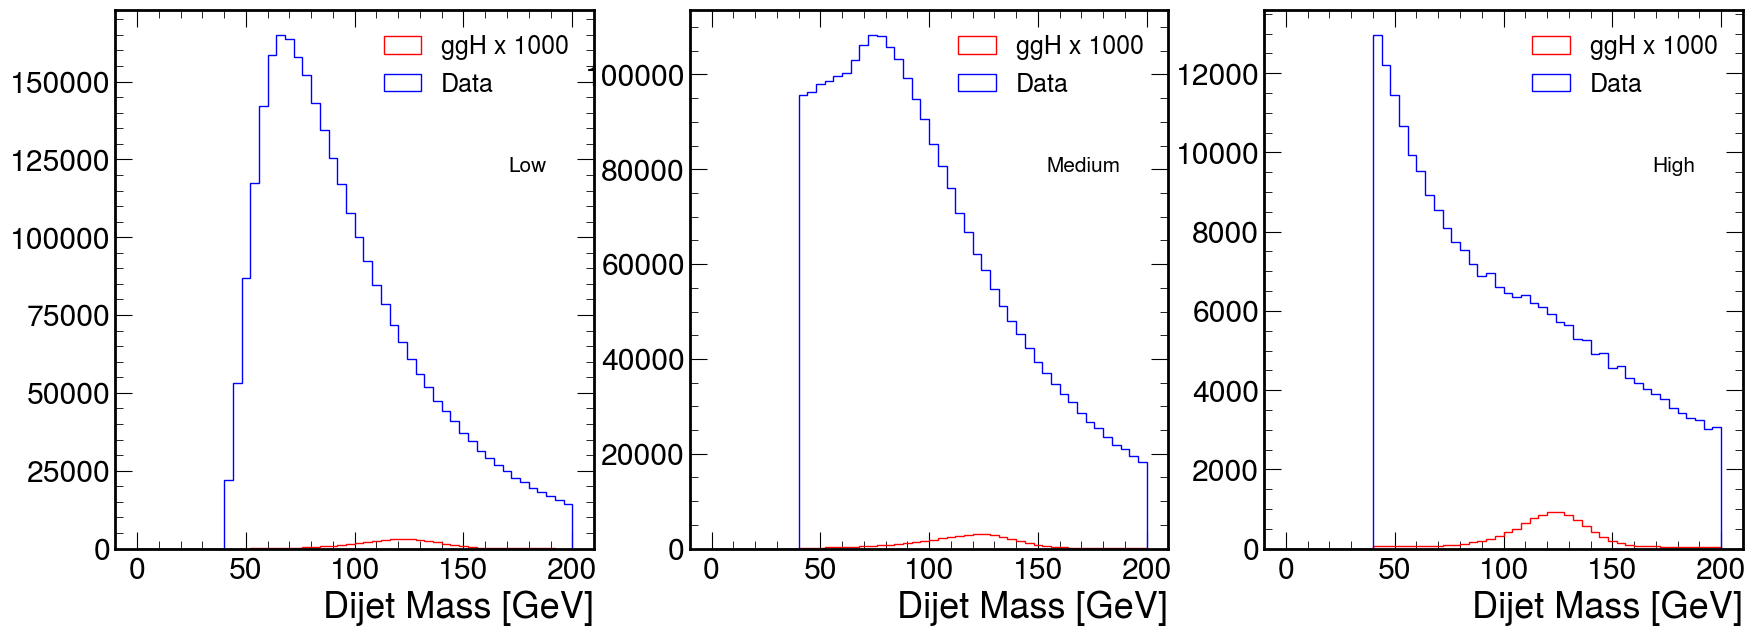

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))
bins = np.linspace(0, 200, 51)
ax[0].hist(df.dijet_mass[mLowS],       bins=bins, weights=df.weights[mLowS]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[0].hist(dfData.dijet_mass[mLowB],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[1].hist(df.dijet_mass[mMediumS],       bins=bins, weights=df.weights[mMediumS]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[1].hist(dfData.dijet_mass[mMediumB],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[2].hist(df.dijet_mass[mHighS],       bins=bins, weights=df.weights[mHighS]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[2].hist(dfData.dijet_mass[mHighB],   bins=bins, histtype=u'step', color='blue', label='Data')
for id,ax_ in enumerate(ax):
    ax_.set_xlabel("Dijet Mass [GeV]")
    ax_.legend(fontsize=18)
    ax_.text(x=0.9,y=0.7,s=["Low","Medium","High"][id], transform = ax_.transAxes, ha='right', fontsize=15)


Regione Low-R1  Significanza: 0.0146
Regione Medium-R1  Significanza: 0.0173
Regione High-R1  Significanza: 0.0165
Regione Low-R2  Significanza: 0.0146
Regione Medium-R2  Significanza: 0.0160
Regione High-R2  Significanza: 0.0146
Regione Low-R3  Significanza: 0.0273
Regione Medium-R3  Significanza: 0.0287
Regione High-R3  Significanza: 0.0257

Matrice delle significanze:
[[0.01461966 0.01734095 0.01649003]
 [0.01464858 0.0160089  0.01460868]
 [0.0273178  0.02866479 0.02567235]]
Sig Total :  0.060808267137199695
Improvement :  1.2058011072579897


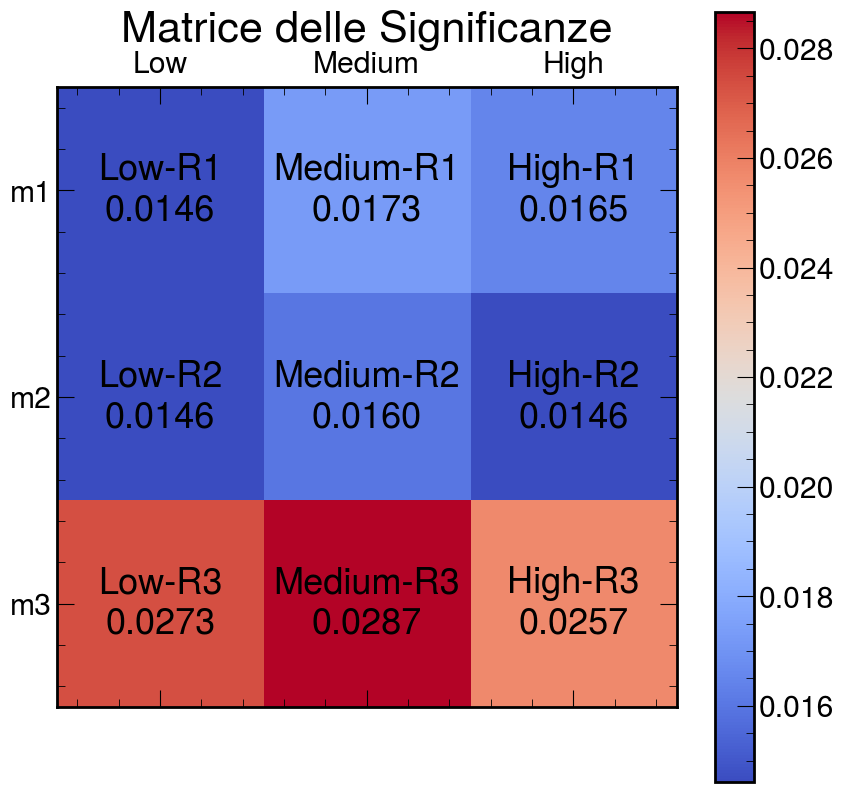

In [19]:
# Use RN - dijet_pt

sigMatrix = np.zeros((3, 3))

# Definizione della matrice delle combinazioni di maschere
masks_S = [[m1S & mLowS, m1S & mMediumS, m1S & mHighS],
              [m2S & mLowS, m2S & mMediumS, m2S & mHighS],
              [m3S & mLowS, m3S & mMediumS, m3S & mHighS]]

masks_B = [[m1B & mLowB, m1B & mMediumB, m1B & mHighB],
              [m2B & mLowB, m2B & mMediumB, m2B & mHighB],
              [m3B & mLowB, m3B & mMediumB, m3B & mHighB]]
labels =   [['Low-R1', 'Medium-R1', 'High-R1'],
            ['Low-R2', 'Medium-R2', 'High-R2'],
            ['Low-R3', 'Medium-R3', 'High-R3']]

# Calcolo delle significanze per ogni combinazione
for i in range(3):
    for j in range(3):
        sig_value = sig(df[masks_S[i][j]], dfData[masks_B[i][j]])
        sigMatrix[i, j] = sig_value
        print("Regione %s  Significanza: %.4f"%(labels[i][j], sig_value))

# Stampa della matrice di significanze
print("\nMatrice delle significanze:")
print(sigMatrix)
print("Sig Total : ", np.sqrt(np.sum(sigMatrix**2)))
print("Improvement : ", np.sqrt(np.sum(sigMatrix**2))/base_sig)


# Creazione della figura e dell'asse
fig, ax = plt.subplots()

# Plot della matrice con una colorbar
cax = ax.matshow(sigMatrix, cmap='coolwarm')

# Aggiunta della colorbar
plt.colorbar(cax)

# Aggiunta delle etichette e dei valori di significanza nelle celle
for i in range(3):
    for j in range(3):
        ax.text(j, i, f'{labels[i][j]}\n{sigMatrix[i, j]:.4f}', 
                ha='center', va='center', color='black')

# Impostazione dei ticks per gli assi
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))

# Impostazione delle etichette per gli assi
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_yticklabels(['m1', 'm2', 'm3'])

# Titolo del grafico
plt.title('Matrice delle Significanze')


# Se necessario, stampa anche i rapporti S/B per ogni regione
sb_ratios = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        sb_ratio_value = sb_ratio(df[masks_S[i][j]], dfData[masks_B[i][j]])
        sb_ratios[i, j] = sb_ratio_value

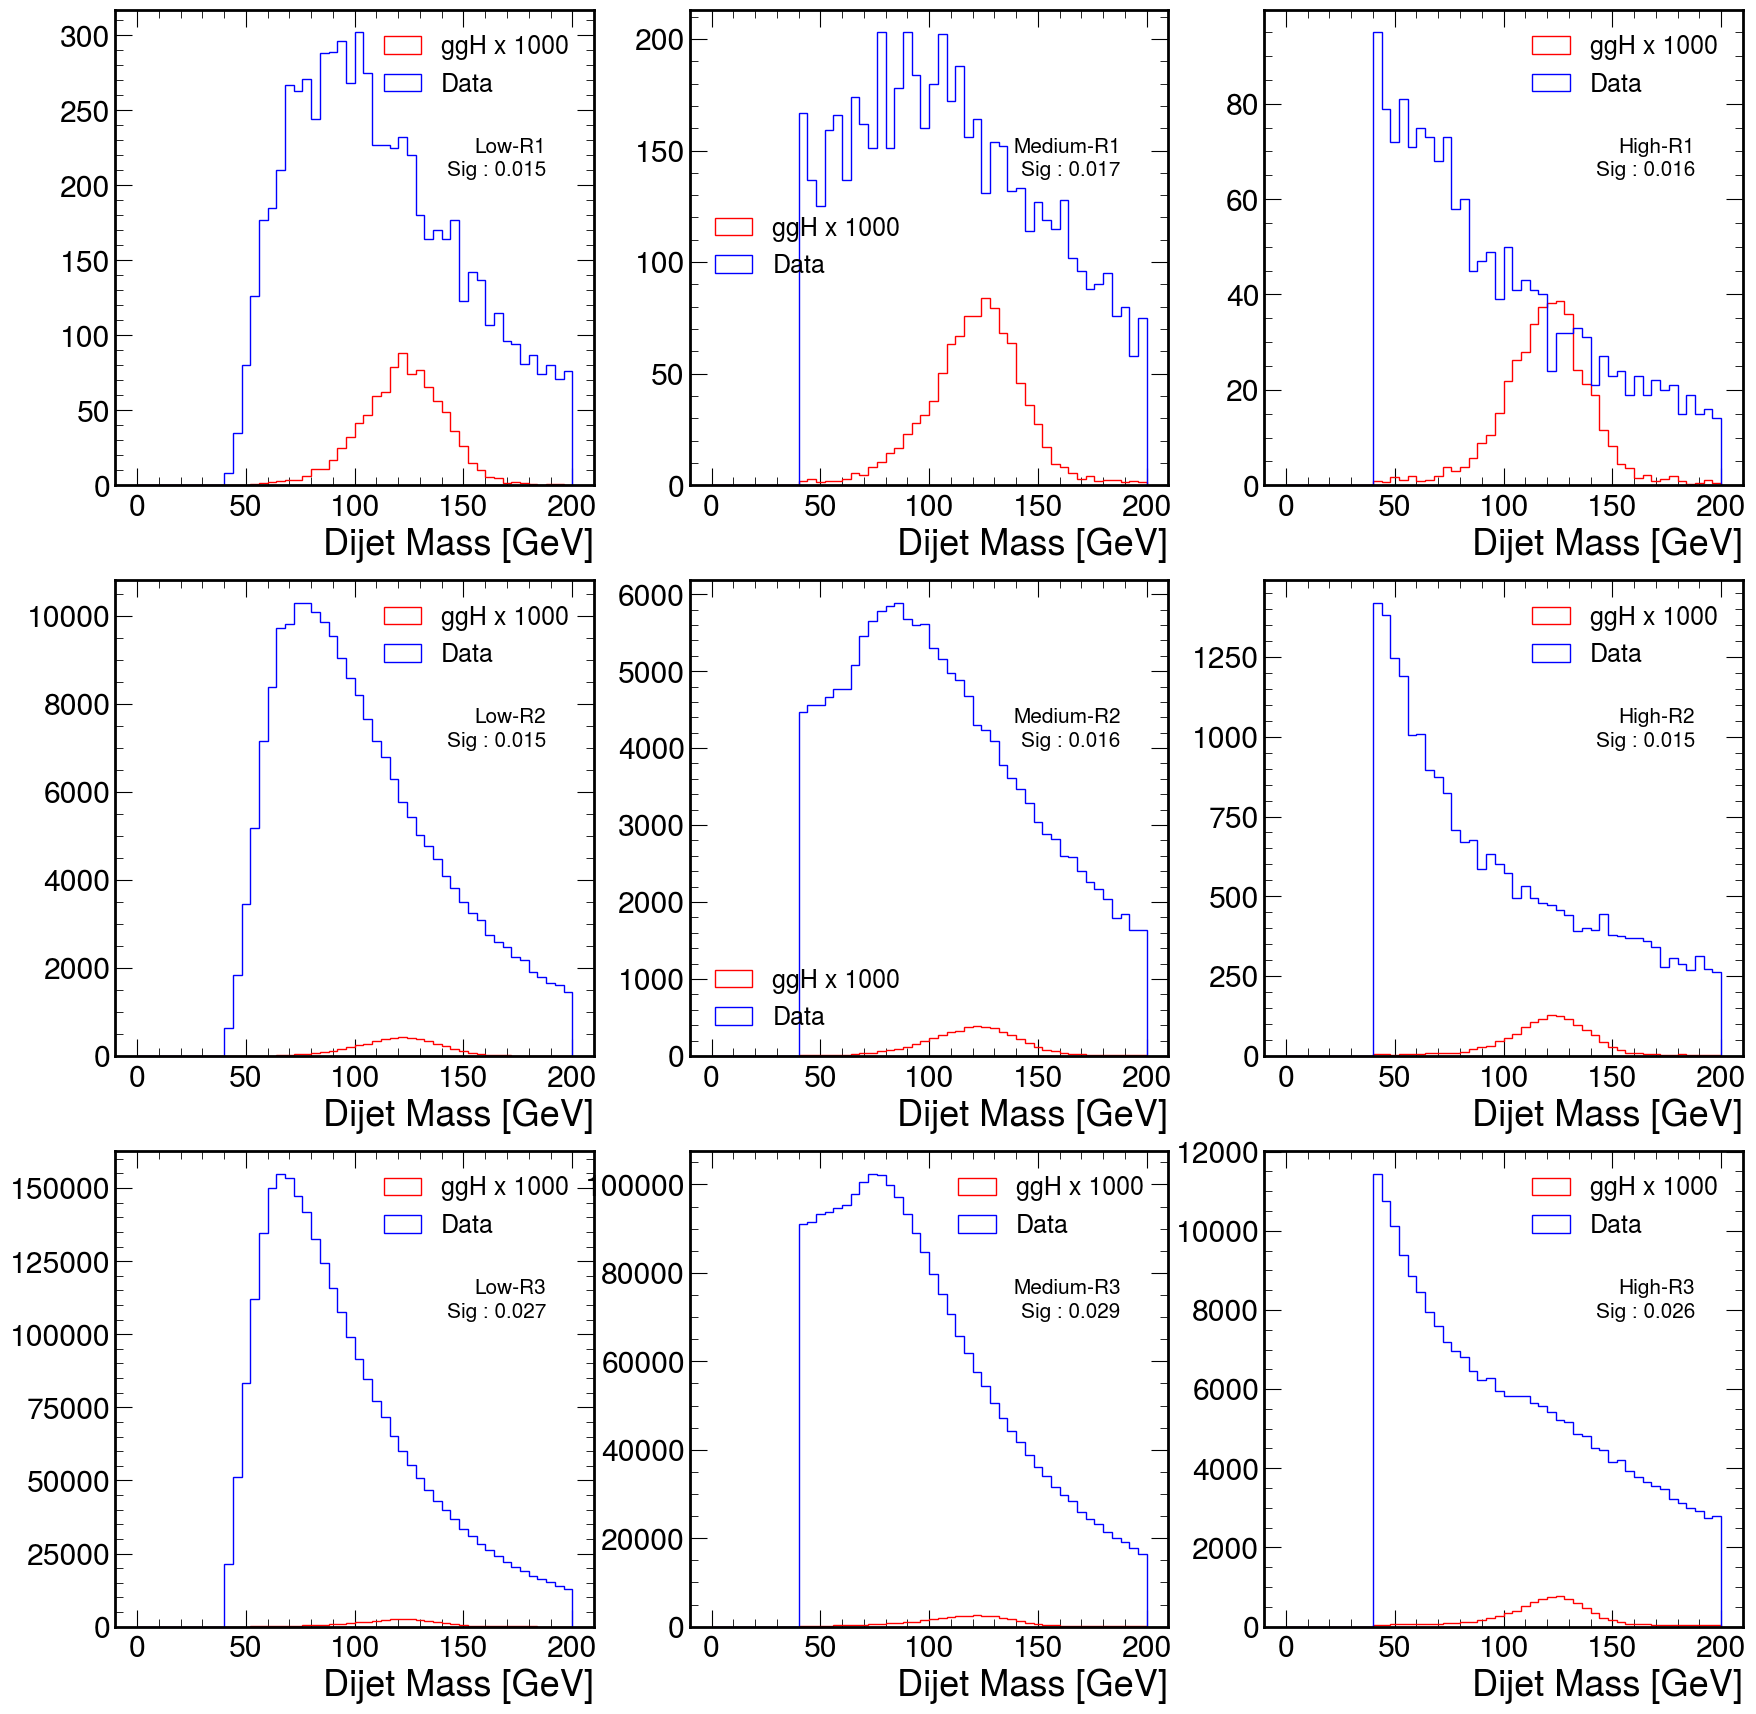

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(21,21))
bins = np.linspace(0, 200, 51)
for i in range(3):
    for j in range(3):
        sig_value = sig(df[masks_S[i][j]], dfData[masks_B[i][j]])
        
        
        ax[i,j].hist(df.dijet_mass[masks_S[i][j]],       bins=bins, weights=df.weights[masks_S[i][j]]*1000, histtype=u'step', color='red', label='ggH x 1000')
        ax[i,j].hist(dfData.dijet_mass[masks_B[i][j]],   bins=bins, histtype=u'step', color='blue', label='Data')



        ax[i,j].set_xlabel("Dijet Mass [GeV]")
        ax[i,j].legend(fontsize=18)
        ax[i,j].text(x=0.9,y=0.7,s=labels[i][j], transform = ax[i,j].transAxes, ha='right', fontsize=15)
        ax[i,j].text(x=0.9,y=0.65,s="Sig : %.3f"%(sig_value), transform = ax[i,j].transAxes, ha='right', fontsize=15)

## BTag

### Optimization of the cut
Let's scan cut1 and cut2 in order to find the best combined significance

In [21]:
from bayes_opt import BayesianOptimization
def combinedSig(cut1, cut2):
    mLowS = df.jet2_btagDeepFlavB<cut1
    mLowB = dfData.jet2_btagDeepFlavB<cut1
    mLowSig = sig(df[mLowS], dfData[mLowB])
    mMediumS = (df.jet2_btagDeepFlavB>cut1) & (df.jet2_btagDeepFlavB<cut2)
    mMediumB = (dfData.jet2_btagDeepFlavB>cut1) & (dfData.jet2_btagDeepFlavB<cut2)
    mMediumSig = sig(df[mMediumS], dfData[mMediumB])
    mHighS = df.jet2_btagDeepFlavB>cut2
    mHighB = dfData.jet2_btagDeepFlavB>cut2
    mHighSig = sig(df[mHighS], dfData[mHighB])
    
    return np.sqrt(mLowSig**2 + mMediumSig**2 + mHighSig**2)


    
pbounds = {
        'cut1': (0.01, 0.5),
        'cut2': (0.55, 0.999)}
optimizer = BayesianOptimization(
f=combinedSig,
pbounds=pbounds,
verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
random_state=1,
allow_duplicate_points=True
)
    
optimizer.maximize(
    init_points=40,
    n_iter=50,
)


|   iter    |  target   |   cut1    |   cut2    |
-------------------------------------------------


| 1         | 0.08459   | 0.2143    | 0.8734    |
| 2         | 0.08239   | 0.01006   | 0.6857    |
| 3         | 0.08347   | 0.08191   | 0.5915    |
| 4         | 0.08393   | 0.1013    | 0.7052    |
| 5         | 0.08474   | 0.2044    | 0.7919    |
| 6         | 0.08464   | 0.2154    | 0.8577    |
| 7         | 0.08215   | 0.1102    | 0.9443    |
| 8         | 0.08108   | 0.02342   | 0.851     |
| 9         | 0.0848    | 0.2145    | 0.8009    |
| 10        | 0.08357   | 0.07879   | 0.6389    |
| 11        | 0.08465   | 0.4024    | 0.9847    |
| 12        | 0.08416   | 0.1636    | 0.8609    |
| 13        | 0.08497   | 0.4394    | 0.9517    |
| 14        | 0.0831    | 0.05167   | 0.5675    |
| 15        | 0.08156   | 0.09322   | 0.9443    |
| 16        | 0.08315   | 0.05819   | 0.7391    |
| 17        | 0.08456   | 0.4794    | 0.7894    |
| 18        | 0.08457   | 0.349     | 0.6917    |
| 19        | 0.08498   | 0.3464    | 0.9247    |
| 20        | 0.08015   | 0.01896   | 0.8868    |


0.3650015873479014 0.8735581918270785
Luminosity used :  0.07610619469026549
Baseline
SIG: 0.05042976554854775
S/B: 3.9288913574734235e-05

R Low 
SIG: 0.013274077641525195
S/B: 1.1835787990760724e-05

R Medium 
SIG: 0.037157811381209514
S/B: 8.506830300281543e-05

R High
SIG: 0.07536073758827919
S/B: 0.00016896431777714346
Final Signifiance (R1+R2+R3)  0.08506553270111378
Improved Significance 1.6868119805003425
Three regions orthogonal :  True
Three regions orthogonal :  True


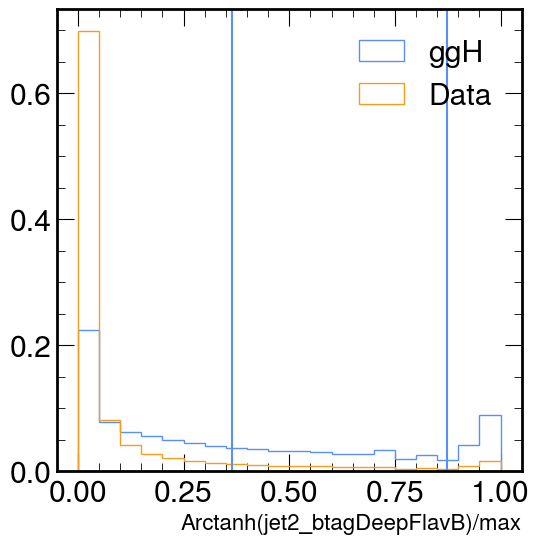

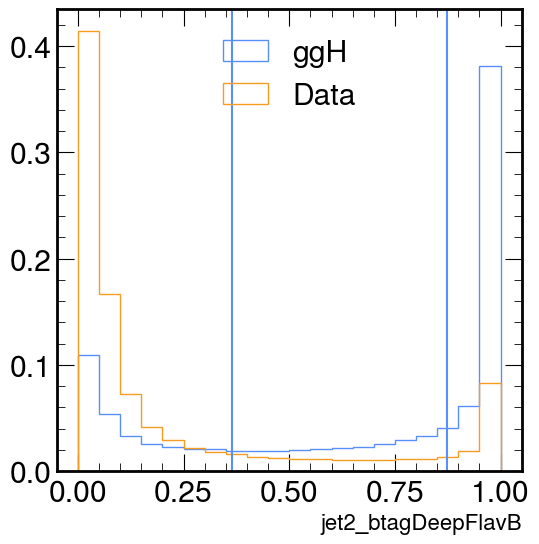

In [22]:
cut1 = optimizer.max["params"]["cut1"]
cut2 = optimizer.max["params"]["cut2"]
print(cut1, cut2)
mLowS = df.jet2_btagDeepFlavB<cut1
mLowB = dfData.jet2_btagDeepFlavB<cut1
mLowSig = sig(df[mLowS], dfData[mLowB])
mMediumS = (df.jet2_btagDeepFlavB>cut1) & (df.jet2_btagDeepFlavB<cut2)
mMediumB = (dfData.jet2_btagDeepFlavB>cut1) & (dfData.jet2_btagDeepFlavB<cut2)
mMediumSig = sig(df[mMediumS], dfData[mMediumB])
mHighS = df.jet2_btagDeepFlavB>cut2
mHighB = dfData.jet2_btagDeepFlavB>cut2
mHighSig = sig(df[mHighS], dfData[mHighB])
base_sig = sig(df, dfData)
base_sb = sb_ratio(df, dfData)
currentLumi = nReal*0.774/1017
print("Luminosity used : ", currentLumi)
print("Baseline")
print("SIG:", base_sig)
print("S/B:", base_sb)

mLowS = df.jet2_btagDeepFlavB<cut1
mLowB = dfData.jet2_btagDeepFlavB<cut1
mLowSig = sig(df[mLowS], dfData[mLowB])
print("\nR Low ")
print("SIG:", mLowSig)
print("S/B:", sb_ratio(df[mLowS], dfData[mLowB]))


mMediumS = (df.jet2_btagDeepFlavB>cut1) & (df.jet2_btagDeepFlavB<cut2)
mMediumB = (dfData.jet2_btagDeepFlavB>cut1) & (dfData.jet2_btagDeepFlavB<cut2)
mMediumSig = sig(df[mMediumS], dfData[mMediumB])
print("\nR Medium ")
print("SIG:", mMediumSig)
print("S/B:", sb_ratio(df[mMediumS], dfData[mMediumB]))

mHighS = df.jet2_btagDeepFlavB>cut2
mHighB = dfData.jet2_btagDeepFlavB>cut2
mHighSig = sig(df[mHighS], dfData[mHighB])
print("\nR High")
print("SIG:", mHighSig)
print("S/B:", sb_ratio(df[mHighS], dfData[mHighB]))

print("Final Signifiance (R1+R2+R3) ", np.sqrt(mLowSig**2 + mMediumSig**2 + mHighSig**2))
print("Improved Significance", np.sqrt(mLowSig**2 + mMediumSig**2 + mHighSig**2)/base_sig)


print("Three regions orthogonal : ",len(df)==(np.sum(mLowS) + np.sum(mMediumS) + np.sum(mHighS)))
print("Three regions orthogonal : ",len(dfData)==(np.sum(mLowB) + np.sum(mMediumB) + np.sum(mHighB)))



fig, ax = plt.subplots(1, 1, figsize=(6, 6))
bins=np.linspace(0,1, 21)
maxS = np.max(np.arctanh(df.jet2_btagDeepFlavB))
maxB = np.max(np.arctanh(dfData.jet2_btagDeepFlavB))
max = np.max((maxS, maxB))

cS = np.histogram((np.arctanh(df.jet2_btagDeepFlavB)/max), bins=bins, weights=W_H)[0]
cB = np.histogram((np.arctanh(dfData.jet2_btagDeepFlavB)/max), bins=bins)[0]
cS, cB = cS/np.sum(cS), cB/np.sum(cB)
ax.hist(bins[:-1], bins=bins,   histtype=u'step', label='ggH', weights=cS)
ax.hist(bins[:-1], bins=bins,   histtype=u'step' ,label='Data', weights=cB)
ax.set_xlabel("Arctanh(jet2_btagDeepFlavB)/max", fontsize=16)
ax.legend()
ax.set_ylim(ax.get_ylim())
ax.vlines(x=[cut1,cut2], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
bins=np.linspace(0,1, 21)

cS = np.histogram(df.jet2_btagDeepFlavB, bins=bins, weights=W_H)[0]
cB = np.histogram(dfData.jet2_btagDeepFlavB, bins=bins)[0]
cS, cB = cS/np.sum(cS), cB/np.sum(cB)
ax.hist(bins[:-1], bins=bins,   histtype=u'step', label='ggH', weights=cS)
ax.hist(bins[:-1], bins=bins,   histtype=u'step' ,label='Data', weights=cB)
ax.set_xlabel("jet2_btagDeepFlavB", fontsize=16)
ax.legend()
ax.set_ylim(ax.get_ylim())
ax.vlines(x=[cut1,cut2], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])


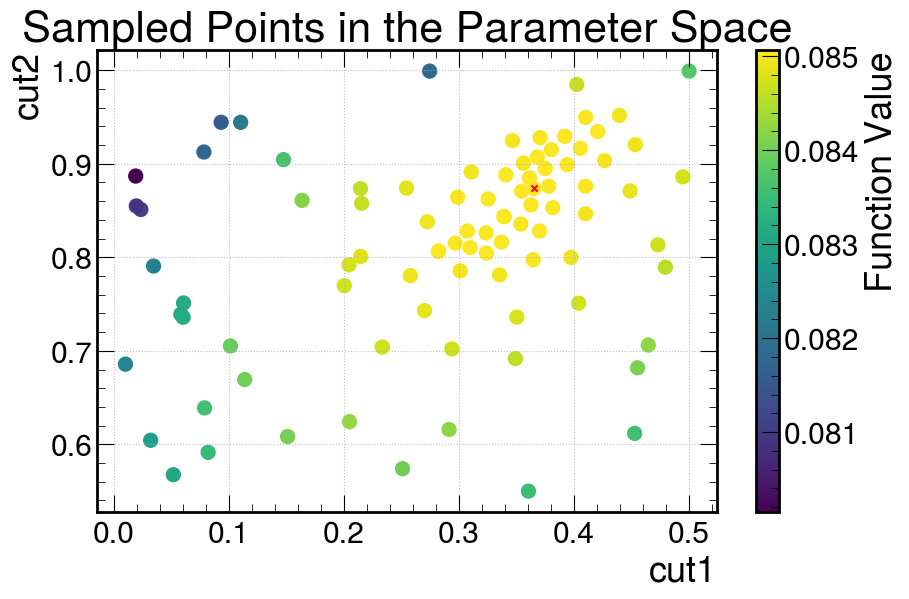

In [23]:
x_cut1 = []
x_cut2 = []
y_values = []

for res in optimizer.res:
    x_cut1.append(res["params"]["cut1"])
    x_cut2.append(res["params"]["cut2"])
    y_values.append(res["target"])

x_cut1 = np.array(x_cut1)
x_cut2 = np.array(x_cut2)
y_values = np.array(y_values)
# Plot the sampled points in the parameter space
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
scatter = ax.scatter(x_cut1, x_cut2, c=y_values, cmap='viridis', s=100)
ax.scatter(cut1, cut2, color='red', marker='x', s=20)
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Function Value')
ax.set_xlabel('cut1')
ax.set_ylabel('cut2')
ax.set_title('Sampled Points in the Parameter Space')
ax.grid(True)


### Use the optimized working points

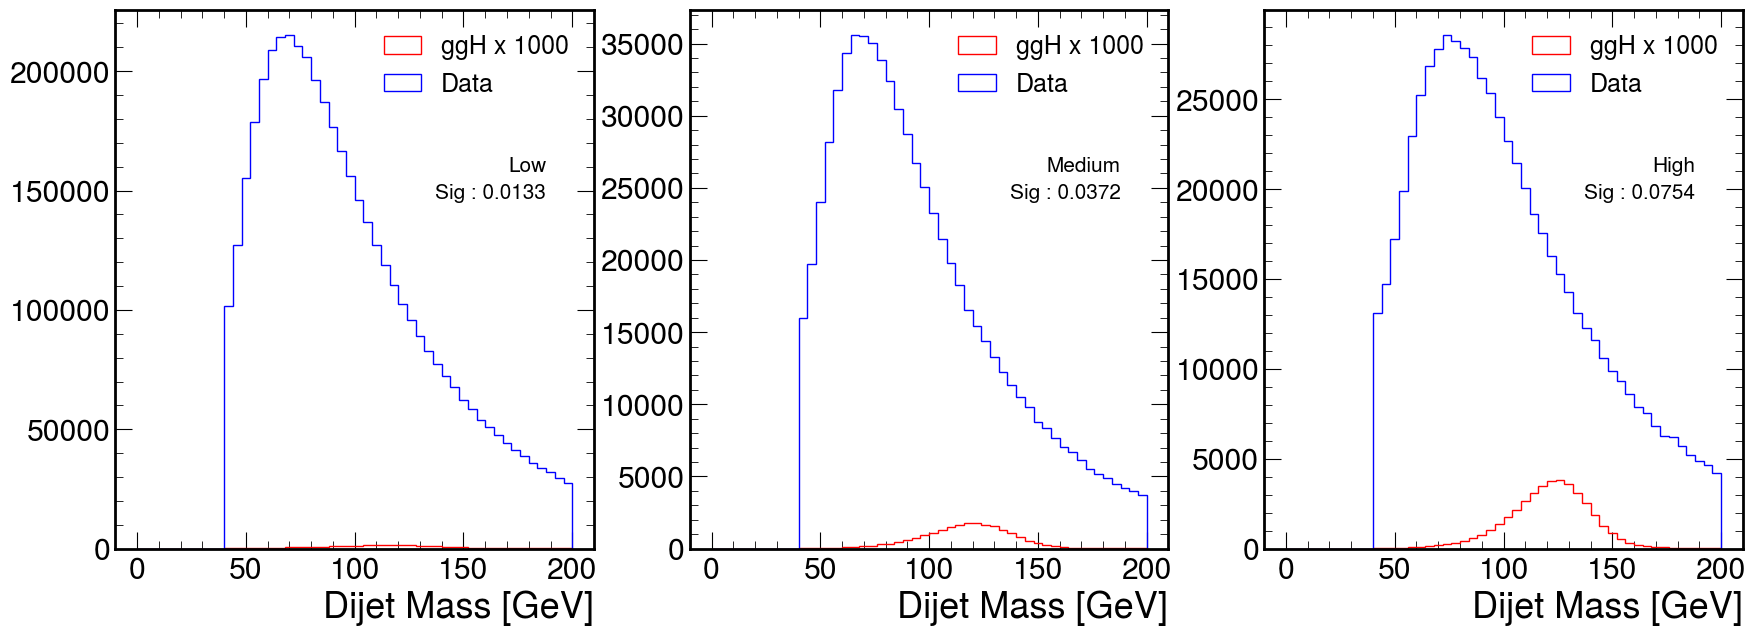

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))
bins = np.linspace(0, 200, 51)
ax[0].hist(df.dijet_mass[mLowS],       bins=bins, weights=df.weights[mLowS]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[0].hist(dfData.dijet_mass[mLowB],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[1].hist(df.dijet_mass[mMediumS],       bins=bins, weights=df.weights[mMediumS]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[1].hist(dfData.dijet_mass[mMediumB],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[2].hist(df.dijet_mass[mHighS],       bins=bins, weights=df.weights[mHighS]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[2].hist(dfData.dijet_mass[mHighB],   bins=bins, histtype=u'step', color='blue', label='Data')
for id,ax_ in enumerate(ax):
    ax_.set_xlabel("Dijet Mass [GeV]")
    ax_.legend(fontsize=18)
    ax_.text(x=0.9,y=0.7,s=["Low","Medium","High"][id], transform = ax_.transAxes, ha='right', fontsize=15)
    ax_.text(x=0.9,y=0.65,s="Sig : %.4f"%(np.round([mLowSig, mMediumSig, mHighSig][id], 4)), transform = ax_.transAxes, ha='right', fontsize=15)

### After NN what happens
Note the idea is to train the NN inside the 3 classes of btag. Now I use the inclusive NN jsut to see how much things change

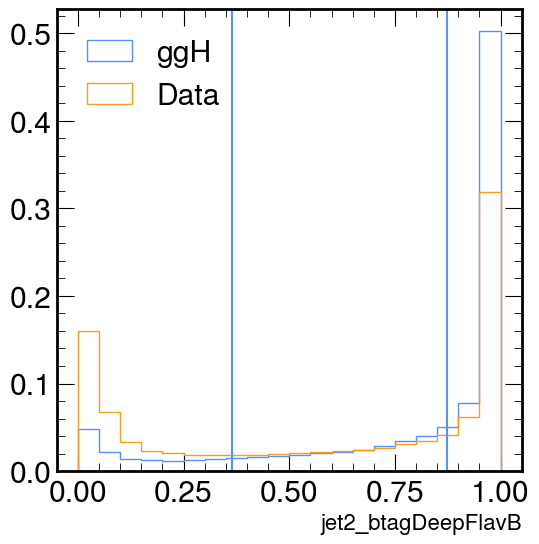

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
bins=np.linspace(0,1, 21)
cS = np.histogram(df.jet2_btagDeepFlavB[maskNN_S], bins=bins, weights=W_H[maskNN_S])[0]
cB = np.histogram(dfData.jet2_btagDeepFlavB[maskNN_B], bins=bins)[0]
cS, cB = cS/np.sum(cS), cB/np.sum(cB)
ax.hist(bins[:-1], bins=bins,   histtype=u'step', label='ggH', weights=cS)
ax.hist(bins[:-1], bins=bins,   histtype=u'step' ,label='Data', weights=cB)
ax.set_xlabel("jet2_btagDeepFlavB", fontsize=16)
ax.legend()
ax.set_ylim(ax.get_ylim())
ax.vlines(x=[cut1,cut2], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])

Luminosity used :  0.07610619469026549
Baseline
SIG: 0.08877098904564035
S/B: 0.0001934449256761449

R Low 
SIG: 0.01608035725740298

R Medium 
SIG: 0.046354498728089444

R High
SIG: 0.08539165960418509
Final Signifiance (R1+R2+R3)  0.09848377009342794
Improved Significance 1.109413910470164


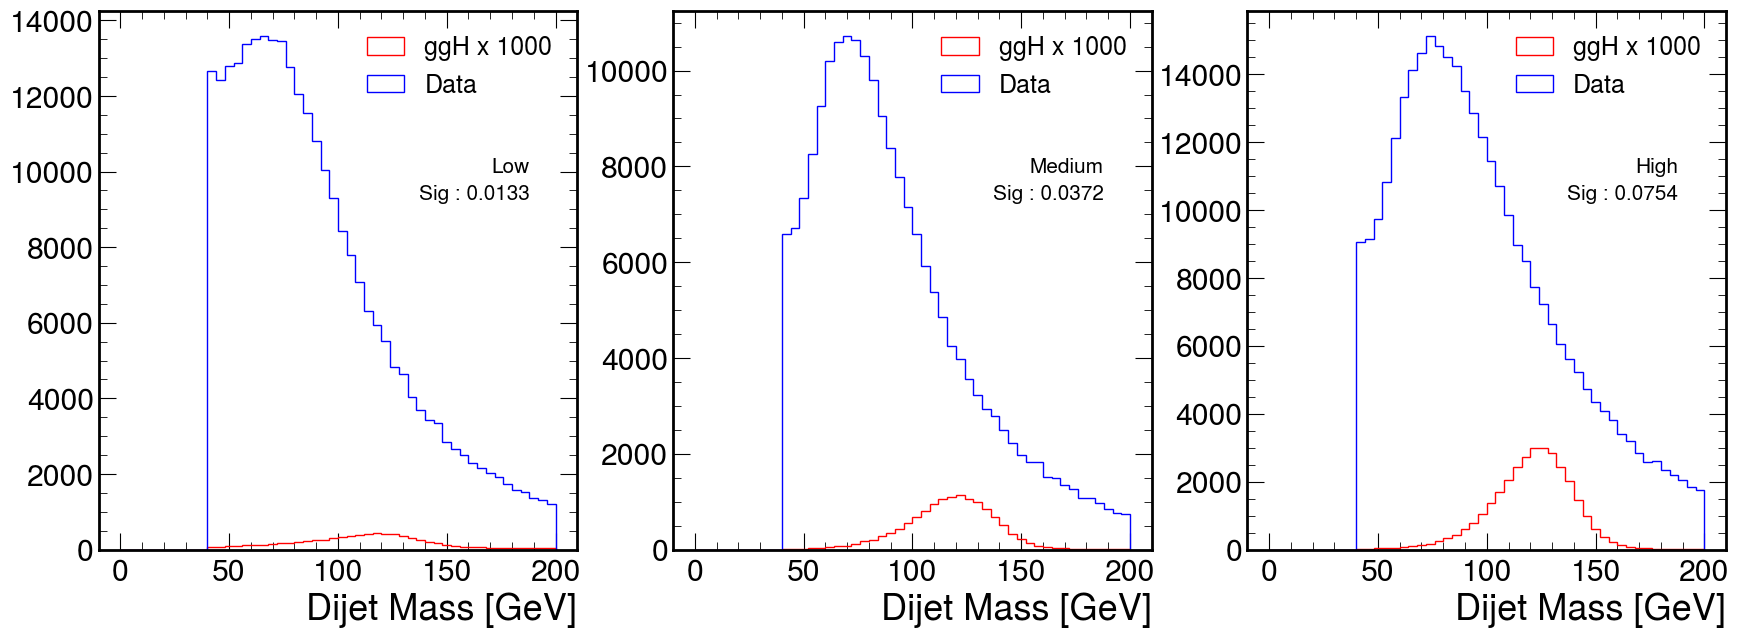

In [30]:
# After NN
base_sig = sig(df[maskNN_S], dfData[maskNN_B])
base_sb = sb_ratio(df[maskNN_S], dfData[maskNN_B])
currentLumi = nReal*0.774/1017
print("Luminosity used : ", currentLumi)
print("Baseline")
print("SIG:", base_sig)
print("S/B:", base_sb)

mLowS = df.jet2_btagDeepFlavB<cut1
mLowB = dfData.jet2_btagDeepFlavB<cut1
mLowSig_NN = sig(df[(mLowS) & (maskNN_S)], dfData[(mLowB) & (maskNN_B)])
print("\nR Low ")
print("SIG:", mLowSig_NN)

mMediumS = (df.jet2_btagDeepFlavB>cut1) & (df.jet2_btagDeepFlavB<cut2)
mMediumB = (dfData.jet2_btagDeepFlavB>cut1) & (dfData.jet2_btagDeepFlavB<cut2)
mMediumSig_NN = sig(df[(mMediumS) & (maskNN_S)], dfData[(mMediumB) & (maskNN_B)])
print("\nR Medium ")
print("SIG:", mMediumSig_NN)


mHighS = df.jet2_btagDeepFlavB>cut2
mHighB = dfData.jet2_btagDeepFlavB>cut2
mHighSig_NN = sig(df[(mHighS) & (maskNN_S)], dfData[(mHighB) & (maskNN_B)])
print("\nR High")
print("SIG:", mHighSig_NN)

print("Final Signifiance (R1+R2+R3) ", np.sqrt(mLowSig_NN**2 + mMediumSig_NN**2 + mHighSig_NN**2))
print("Improved Significance", np.sqrt(mLowSig_NN**2 + mMediumSig_NN**2 + mHighSig_NN**2)/base_sig)

fig, ax = plt.subplots(1, 3, figsize=(21,7))
bins = np.linspace(0, 200, 51)
ax[0].hist(df.dijet_mass[(mLowS) & (maskNN_S)],       bins=bins, weights=df.weights[(mLowS) & (maskNN_S)]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[0].hist(dfData.dijet_mass[(mLowB) & (maskNN_B)],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[1].hist(df.dijet_mass[(mMediumS) & (maskNN_S)],       bins=bins, weights=df.weights[(mMediumS) & (maskNN_S)]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[1].hist(dfData.dijet_mass[(mMediumB) & (maskNN_B)],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[2].hist(df.dijet_mass[(mHighS) & (maskNN_S)],       bins=bins, weights=df.weights[(mHighS) & (maskNN_S)]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[2].hist(dfData.dijet_mass[(mHighB) & (maskNN_B)],   bins=bins, histtype=u'step', color='blue', label='Data')
for id,ax_ in enumerate(ax):
    ax_.set_xlabel("Dijet Mass [GeV]")
    ax_.legend(fontsize=18)
    ax_.text(x=0.9,y=0.7,s=["Low","Medium","High"][id], transform = ax_.transAxes, ha='right', fontsize=15)
    ax_.text(x=0.9,y=0.65,s="Sig : %.4f"%(np.round([mLowSig, mMediumSig, mHighSig][id], 4)), transform = ax_.transAxes, ha='right', fontsize=15)



### Combined

Regione Low-R1  Significanza: 0.0071
Regione Medium-R1  Significanza: 0.0133
Regione High-R1  Significanza: 0.0218
Regione Low-R2  Significanza: 0.0072
Regione Medium-R2  Significanza: 0.0150
Regione High-R2  Significanza: 0.0252
Regione Low-R3  Significanza: 0.0117
Regione Medium-R3  Significanza: 0.0329
Regione High-R3  Significanza: 0.0689

Matrice delle significanze:
[[0.0070605  0.0132877  0.02175561]
 [0.00715839 0.01504151 0.02521793]
 [0.01171842 0.03291635 0.06888903]]
Sig Total :  0.08706123903428907
Improvement :  1.7263859565334865


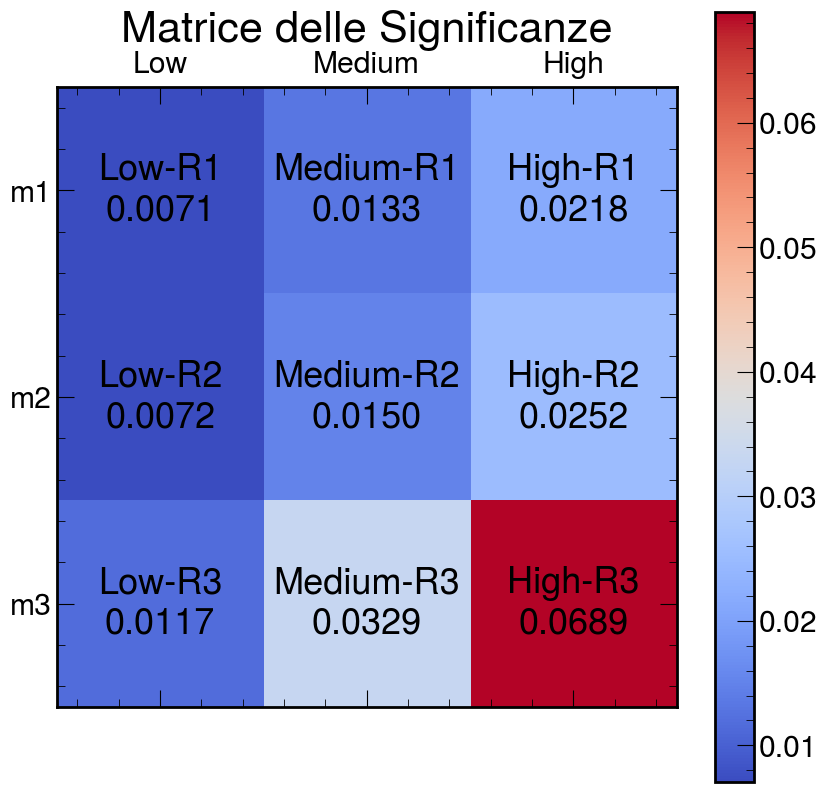

In [25]:

# Matrice per immagazzinare le significanze
sigMatrix = np.zeros((3, 3))

# Definizione della matrice delle combinazioni di maschere
masks_S = [[m1S & mLowS, m1S & mMediumS, m1S & mHighS],
              [m2S & mLowS, m2S & mMediumS, m2S & mHighS],
              [m3S & mLowS, m3S & mMediumS, m3S & mHighS]]

masks_B = [[m1B & mLowB, m1B & mMediumB, m1B & mHighB],
              [m2B & mLowB, m2B & mMediumB, m2B & mHighB],
              [m3B & mLowB, m3B & mMediumB, m3B & mHighB]]
labels =   [['Low-R1', 'Medium-R1', 'High-R1'],
            ['Low-R2', 'Medium-R2', 'High-R2'],
            ['Low-R3', 'Medium-R3', 'High-R3']]

# Calcolo delle significanze per ogni combinazione
for i in range(3):
    for j in range(3):
        sig_value = sig(df[masks_S[i][j]], dfData[masks_B[i][j]])
        sigMatrix[i, j] = sig_value
        print("Regione %s  Significanza: %.4f"%(labels[i][j], sig_value))

# Stampa della matrice di significanze
print("\nMatrice delle significanze:")
print(sigMatrix)
print("Sig Total : ", np.sqrt(np.sum(sigMatrix**2)))
print("Improvement : ", np.sqrt(np.sum(sigMatrix**2))/base_sig)


# Creazione della figura e dell'asse
fig, ax = plt.subplots()

# Plot della matrice con una colorbar
cax = ax.matshow(sigMatrix, cmap='coolwarm')

# Aggiunta della colorbar
plt.colorbar(cax)

# Aggiunta delle etichette e dei valori di significanza nelle celle
for i in range(3):
    for j in range(3):
        ax.text(j, i, f'{labels[i][j]}\n{sigMatrix[i, j]:.4f}', 
                ha='center', va='center', color='black')

# Impostazione dei ticks per gli assi
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))

# Impostazione delle etichette per gli assi
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_yticklabels(['m1', 'm2', 'm3'])

# Titolo del grafico
plt.title('Matrice delle Significanze')


# Se necessario, stampa anche i rapporti S/B per ogni regione
sb_ratios = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        sb_ratio_value = sb_ratio(df[masks_S[i][j]], dfData[masks_B[i][j]])
        sb_ratios[i, j] = sb_ratio_value

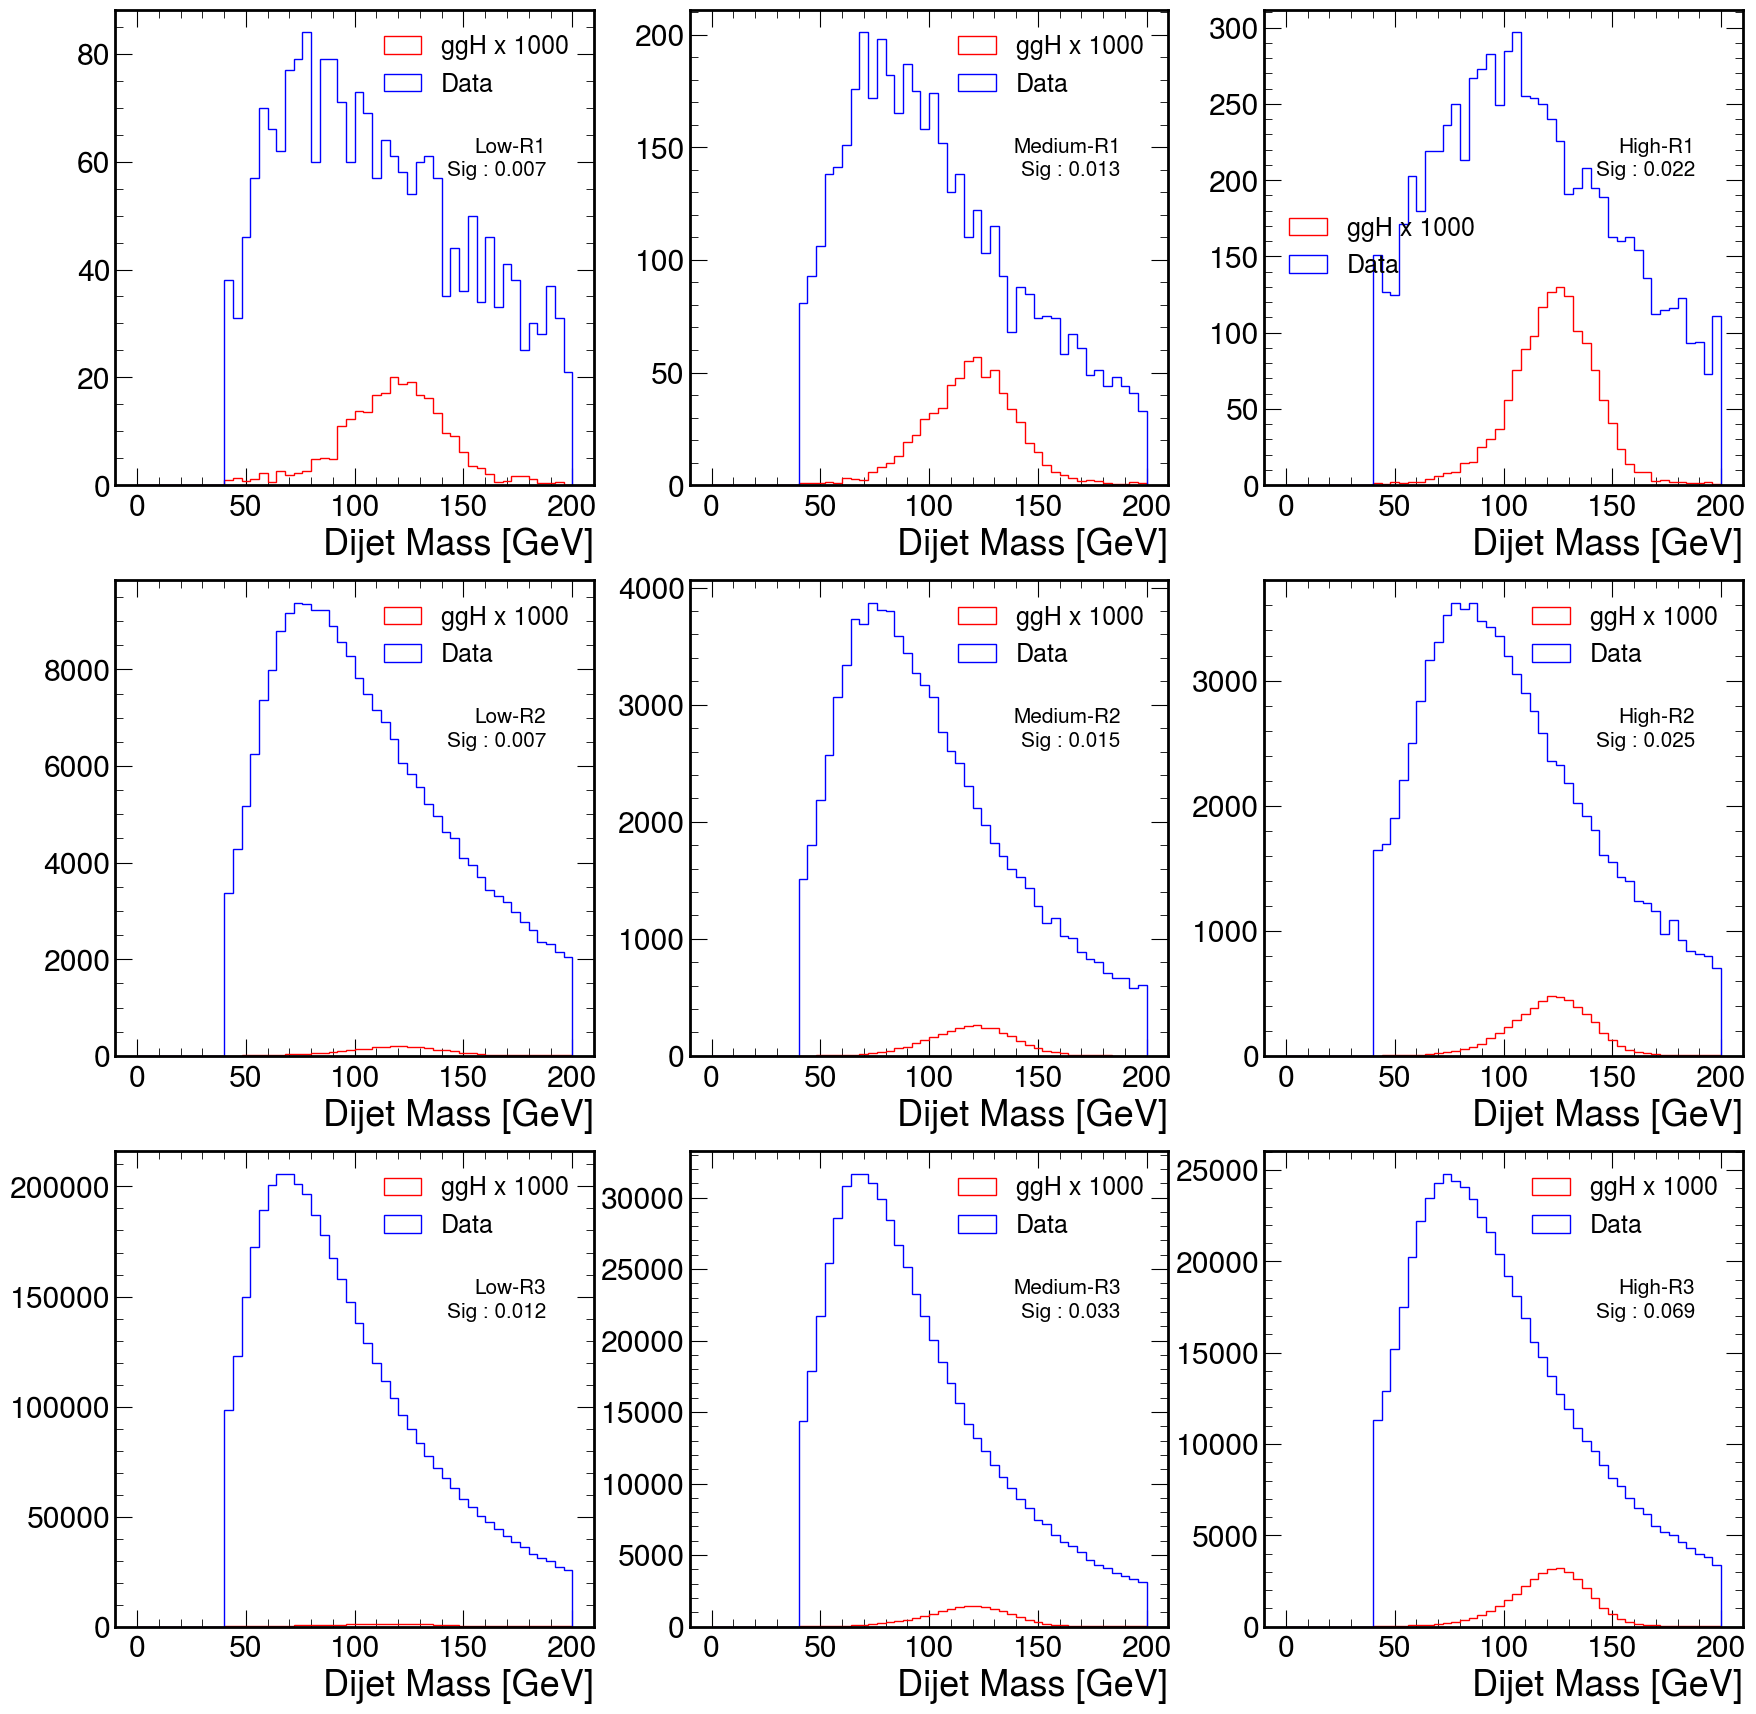

In [26]:
fig, ax = plt.subplots(3, 3, figsize=(21,21))
bins = np.linspace(0, 200, 51)
for i in range(3):
    for j in range(3):
        sig_value = sig(df[masks_S[i][j]], dfData[masks_B[i][j]])
        
        
        ax[i,j].hist(df.dijet_mass[masks_S[i][j]],       bins=bins, weights=df.weights[masks_S[i][j]]*1000, histtype=u'step', color='red', label='ggH x 1000')
        ax[i,j].hist(dfData.dijet_mass[masks_B[i][j]],   bins=bins, histtype=u'step', color='blue', label='Data')



        ax[i,j].set_xlabel("Dijet Mass [GeV]")
        ax[i,j].legend(fontsize=18)
        ax[i,j].text(x=0.9,y=0.7,s=labels[i][j], transform = ax[i,j].transAxes, ha='right', fontsize=15)
        ax[i,j].text(x=0.9,y=0.65,s="Sig : %.3f"%(sig_value), transform = ax[i,j].transAxes, ha='right', fontsize=15)